# Unsupervised Learning - Feature Space

## Importing Libraries

In addition to some of the libraries you have already seen in previous module, we would also need additional libraries as mentioned below.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import pandas.plotting as ptp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.gridspec as gridspec
from sklearn import cluster
import time

## Well Log Plots

Function copied from 1.1 Data Exploration

In [2]:
def create_plot(wellname, dataframe, curves_to_plot, depth_curve, log_curves=[]):
    """
    This create_plot function takes a number of arguments (inputs):
    wellname: the wellname as a string
    dataframe: the dataframe for the selected well
    curves_to_plot: a list of logging curves / dataframe columns we are wanting to plot
    depth_curve: the the depth curve we are wanting to plot against
    log_curves: a list of curves that need to be displayed on a logarithmic scale
    """
    # Count the number of tracks we need
    num_tracks = len(curves_to_plot)
    
    # Setup the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(num_tracks*2, 10))
    
    # Create a super title for the entire plot
    fig.suptitle(wellname, fontsize=20, y=1.05)
    
    # Loop through each curve in curves_to_plot and create a track with that data
    for i, curve in enumerate(curves_to_plot):
        
        
        ax[i].plot(dataframe[curve], depth_curve, linestyle='none', marker='o', markersize=2 )
        
        # Setup a few plot cosmetics
        ax[i].set_title(curve, fontsize=14, fontweight='bold')
        ax[i].grid(which='major', color='lightgrey', linestyle='-')
        
        # We want to pass in the deepest depth first, so we are displaying the data 
        # from shallow to deep
        ax[i].set_ylim(depth_curve.max(), depth_curve.min())

        # Only set the y-label for the first track. Hide it for the rest
        if i == 0:
            ax[i].set_ylabel('DEPTH (m)', fontsize=18, fontweight='bold')
        else:
            plt.setp(ax[i].get_yticklabels(), visible = False)
        
        # Check to see if we have any logarithmic scaled curves
        if curve in log_curves:
            ax[i].set_xscale('log')
            ax[i].grid(which='minor', color='lightgrey', linestyle='-')
    
    plt.tight_layout()
    plt.show()


## Import Data

Import data prepared after outlier detection and cleaning step.

In [3]:
df = pd.read_csv("processed_data/UL_Features.csv")

## Check and Verify Data
Lets quickly check column names and describe data to ensure all imported log values are good and useable. The first column "Unnamed" is the index variable. Also column called "wellName" is not shown in describe as its values are all text

In [4]:
df.head()

Unnamed: 0    wellName      MD    CALI       GR    RHOB    NPHI  \
0          32  15/9-F-1 A  3434.2  8.6250  72.7456  2.6270  0.3134   
1          33  15/9-F-1 A  3434.3  8.6250  72.5227  2.5898  0.3055   
2          34  15/9-F-1 A  3434.4  8.6249  70.1513  2.5523  0.2982   
3          35  15/9-F-1 A  3434.5  8.5781  64.3046  2.5186  0.2933   
4          36  15/9-F-1 A  3434.6  8.5781  58.7215  2.4902  0.2836   

   RACEHM_l10  RACELM_l10  RPCEHM_l10  RPCELM_l10    PHIF     SW     VSH  
0   -0.146667   -0.227165    0.233326    0.004794  0.0200  1.000  0.9659  
1   -0.104964   -0.233959    0.332459    0.019116  0.0422  1.000  0.9626  
2   -0.075514   -0.239804    0.410355    0.042654  0.0648  1.000  0.9268  
3   -0.061530   -0.242528    0.429914    0.054000  0.0851  1.000  0.8382  
4   -0.052860   -0.242452    0.413484    0.056829  0.1022  0.882  0.7535

In [5]:
df.describe().T

count          mean          std          min          25%  \
Unnamed: 0  20088.0  13355.935135  8391.424963    32.000000  6290.750000   
MD          20088.0   3816.924676   416.466483  3224.900000  3489.775000   
CALI        20088.0      8.625315     0.066341     8.500000     8.556900   
GR          20088.0     39.781249    18.378084     7.008700    26.050250   
RHOB        20088.0      2.377120     0.140259     2.105000     2.255100   
NPHI        20088.0      0.187071     0.042097     0.057000     0.161000   
RACEHM_l10  20088.0      0.577000     0.465149    -0.704653     0.239543   
RACELM_l10  20088.0      0.513256     0.395997    -0.629117     0.220108   
RPCEHM_l10  20088.0      0.677861     0.534011    -0.675923     0.288249   
RPCELM_l10  20088.0      0.595955     0.473612    -0.682564     0.248672   
PHIF        20088.0      0.157622     0.072479     0.001000     0.094300   
SW          20088.0      0.571753     0.335725     0.087000     0.264000   
VSH         20088.0      0.280024     0.158276     0.000100     0.165000   

                     50%           75%           max  
Unnamed: 0  12600.500000  21639.250000  27844.000000  
MD           3663.300000   4123.525000   4744.000000  
CALI            8.625000      8.672000      8.828000  
GR             37.746400     50.558100    107.456700  
RHOB            2.366000      2.495400      2.898000  
NPHI            0.187500      0.213800      0.357000  
RACEHM_l10      0.527088      0.902278      1.778115  
RACELM_l10      0.467312      0.801177      1.987505  
RPCEHM_l10      0.615303      1.047937      1.998769  
RPCELM_l10      0.549003      0.942603      1.856638  
PHIF            0.174000      0.220800      0.282000  
SW              0.468400      1.000000      1.000000  
VSH             0.259000      0.362000      0.965900

## Visualizing Data using LogPlots

We would be following the same recipe as from 1.1 Data Exploration. Straight lines in logplots are due to outlier cleaning. 

In [6]:
# As there are 5 wells within the dataframe, if we try to plot all of that data in one go, we will have mixed measurements from all of the wells. 
# To resolve this, we can create a new dataframe that is grouped by the wellname
grouped =df.groupby('wellName')
#To have more control over the well we are wanting to plot, we can split the grouped dataframe into single dataframes 
# and store them within a list. This will allow us to access specific wells by passing in a list index value.
# Create empty lists
dfs_wells = []
wellnames = []

#Split up the data by well
for well, data in grouped:
    dfs_wells.append(data)
    wellnames.append(well)

In [7]:
# Before we plot the data, we need to specify the curves we are wanting to plot, 
# and also specify which of those curves are logarithmicaly scaled.
# Please note that we would not be plotting the output properties such as PHIF, SW and VSH. In the course of unsupervised
# learning, we are only interesting in features and sample space.
curves_to_plot = ['CALI', 'GR', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10', 'RPCELM_l10', 'RHOB', 'NPHI']
#logarithmic_curves = ['RACEHM', 'RACELM', 'RPCEHM', 'RPCELM']

Index: 0 - 15/9-F-1 A


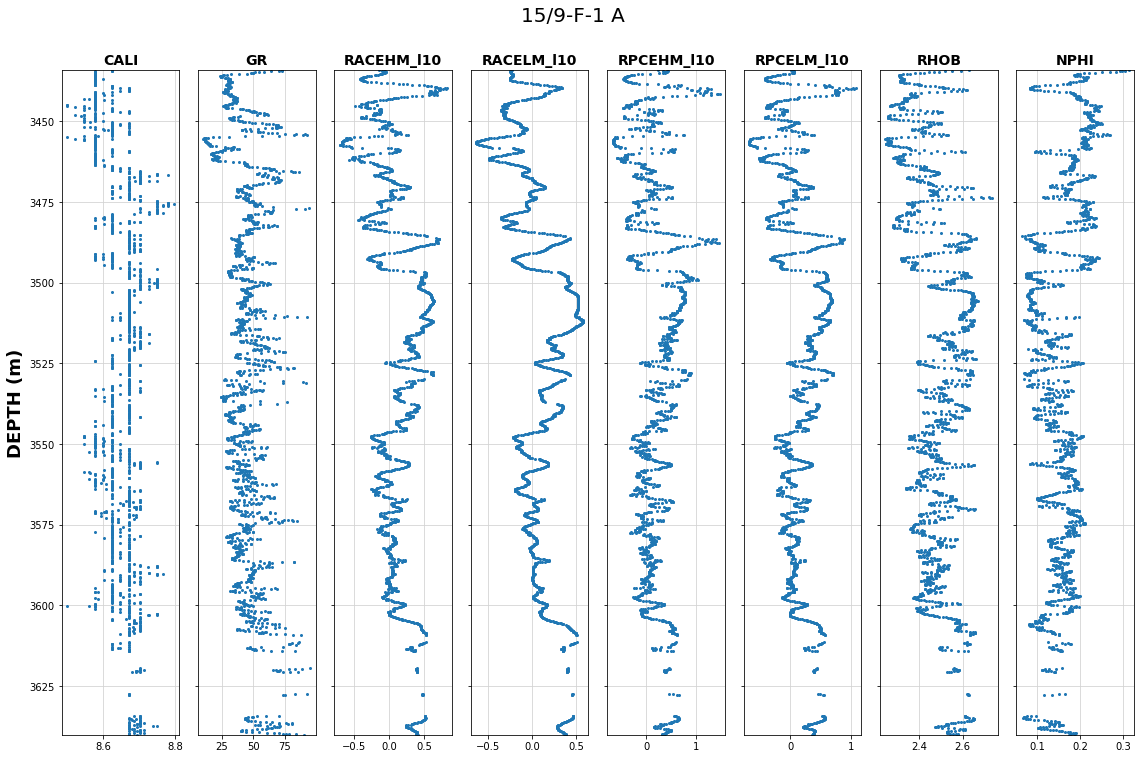

Index: 1 - 15/9-F-1 B


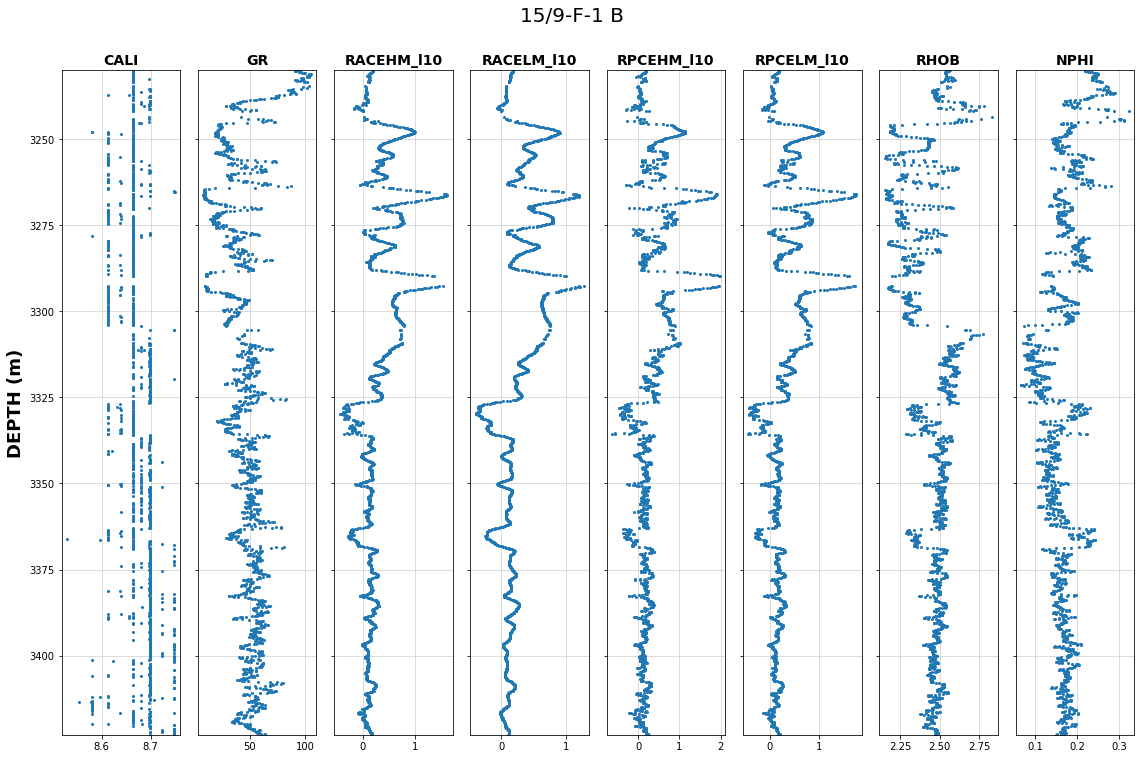

Index: 2 - 15/9-F-1 C


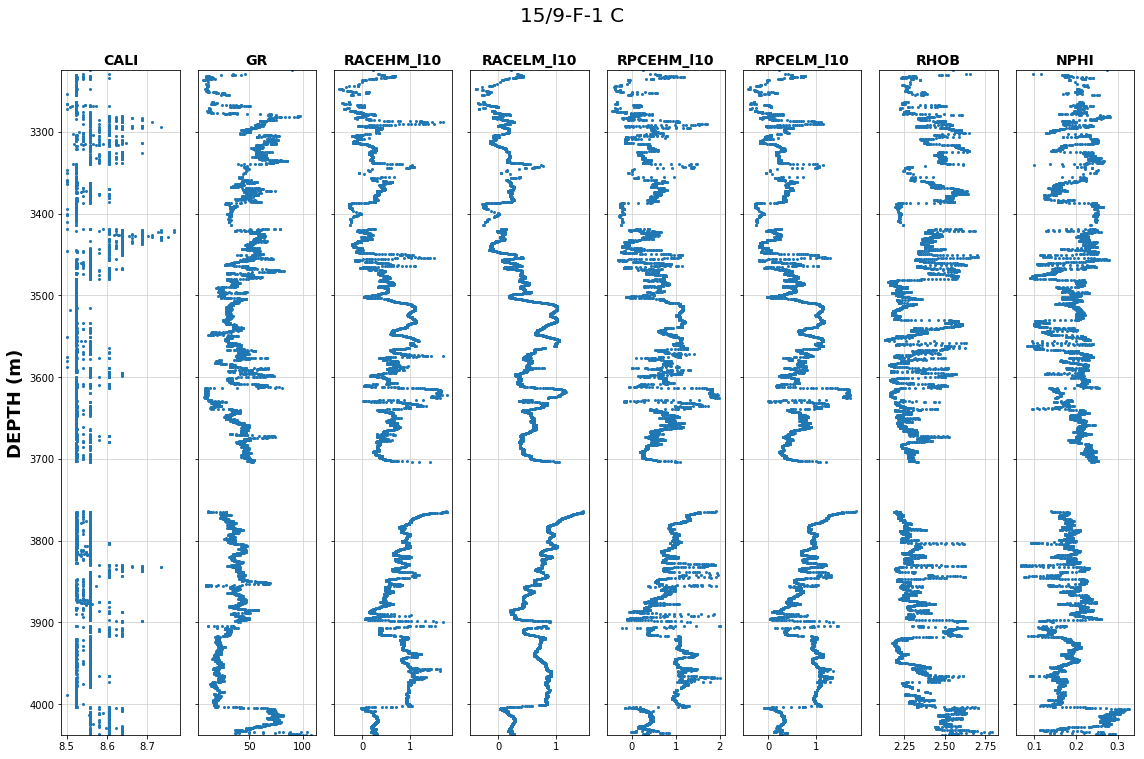

Index: 3 - 15/9-F-11 A


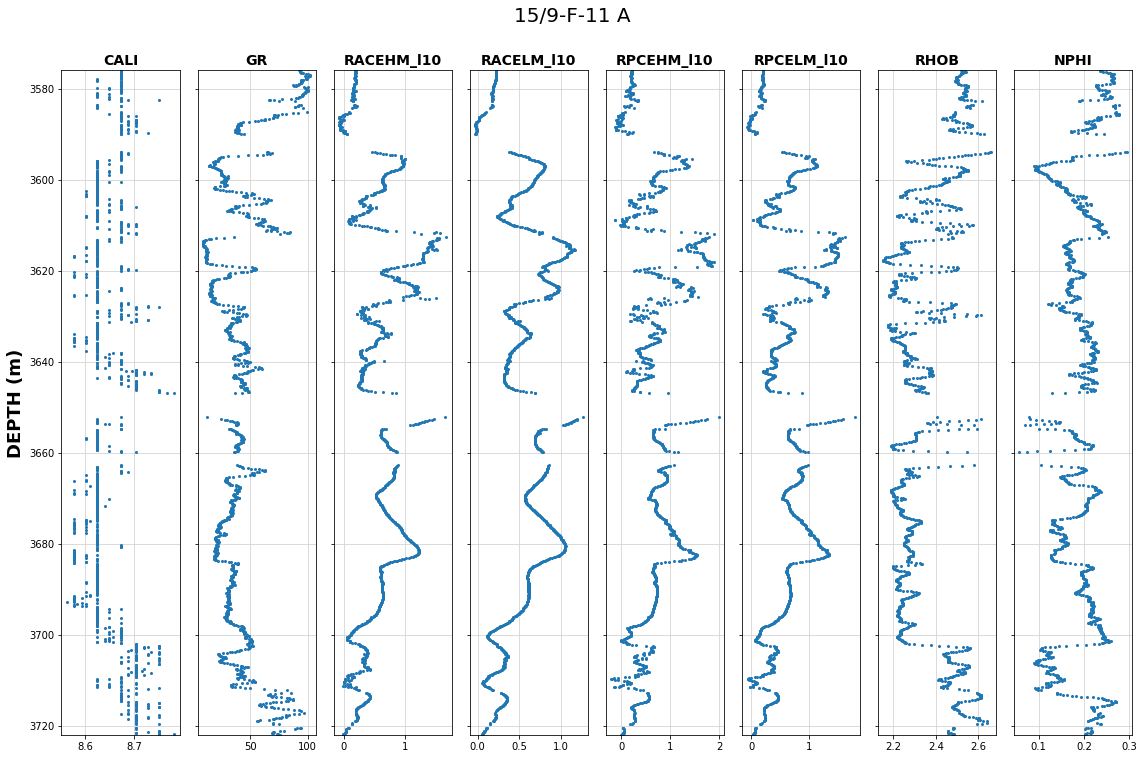

Index: 4 - 15/9-F-11 B


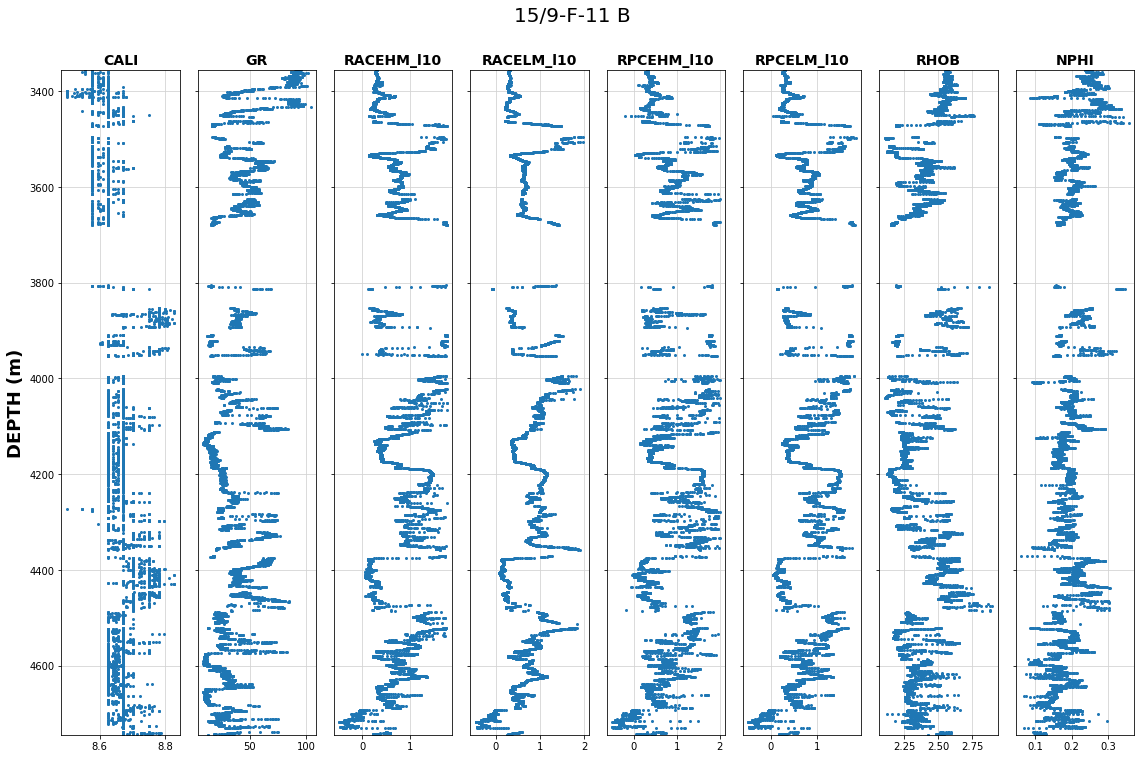

In [8]:
# Lets plot all of the wells one by one
# If we loop through the wellnames list we can get the index number and the associated wellname.

for i, well in enumerate(wellnames):
    print(f'Index: {i} - {well}')
    create_plot(wellnames[i], dfs_wells[i], curves_to_plot, dfs_wells[i]['MD'])

## Choosing Data for Unsupervised Learning

Caliper has already been accounted for during outlier detection, so we would not be using it for unsupervised learning in feature space. Well names, depths and output properties are not needed either. For rest of the input log curves, GR, resistivities, density and neutron, we would like to understand relationships/correlations and then select the best possible logs for clustering in sample (depth) space.

In [9]:
# Create a new dataframe by dropping unneeded log curves from original data frame.

dful = df.drop(['CALI', 'MD', 'wellName', 'Unnamed: 0', 'PHIF', 'VSH', 'SW'], 1)

# Feature Selection

One of the main motivations to do unsupervised learning in feature space is to select independent and significant features for any other subsequent ML/AI workflow. In our case features are input log measurements. The reasons we do this is:

1. Remove redundant or dependent measurments - If there are a few highly correlated or dependent measurements in our dataset, then we would like to keep only one which is the most representative to problem we are trying to solve. Rest could easily be removed to avoid redundancy and reduce computational resources required in subsequent steps.
2. Reduce overall noise in input measurements - Keeping redundant or highly correlated measurements doesn't help in any data science workflow but only adds to the overall noise in input dataset. 

There are a number of ways in which right features or input measurements could be selected, ranging from simple scatter plots for small set of features to more biplots for larger set. It is never a bad idea to do all of these to ensure the best subset is picked. 

## Scatter Plots
Now we would like to know various log curves are correlated to each other to be able to select the ones which matter the most. There are number of ways this could be done.

We saw Scatter plots in 1.1 Outlier Detection. This type of plot is used to visually understand the distribution and correlation of the input features. For unsupervised or supervised learning, it is best to choose uncorrelated inputs. Out of correlated logs, the most representative for the outputs should be chosen.

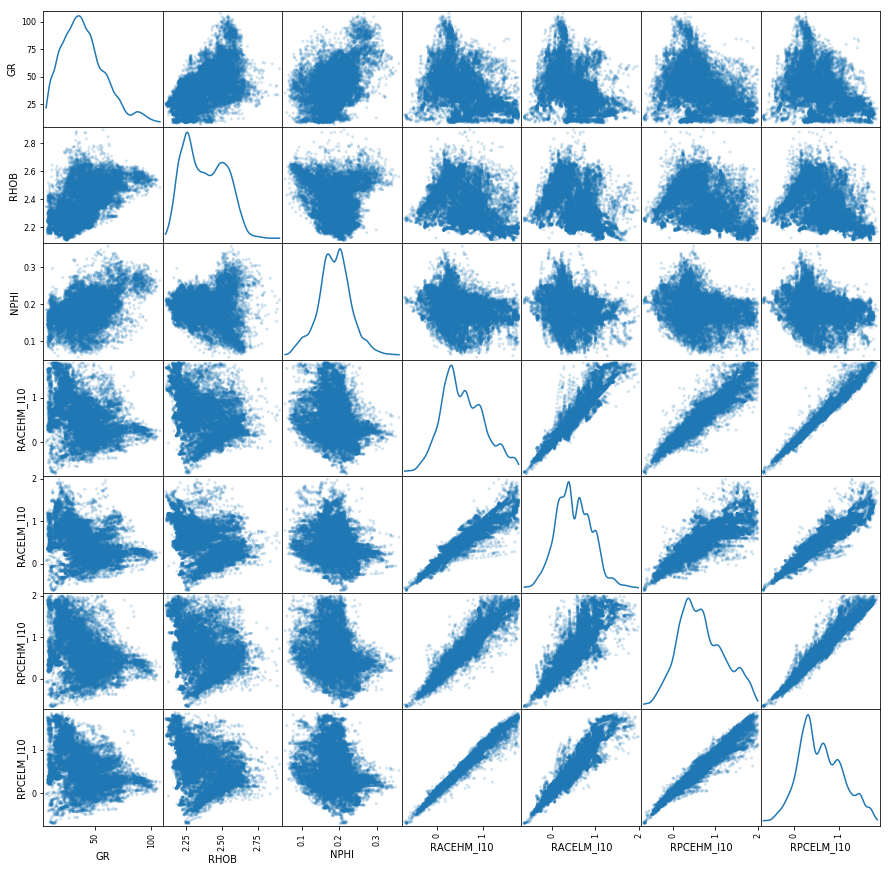

In [10]:
ptp.scatter_matrix(dful, alpha=0.2, figsize = (15,15), diagonal = 'kde');

## Correlation Heatmap

Same information as above could also be visualized using correlation heatmap, especially if the number if inputs are quite high. In these heatmaps, we display color coded correlation matrix with red as correlated and cyan as anti-correlated. 

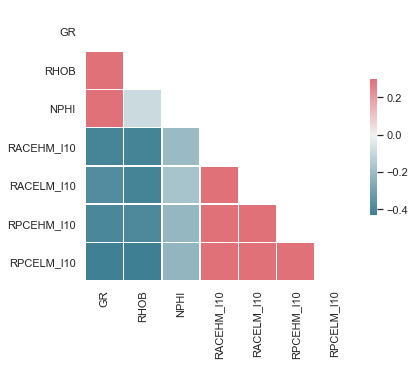

In [11]:
sns.set(style="white")

# Compute the correlation matrix
corr = dful.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Principal Component Analysis

PCA is dimension reduction technique which takes set of possibly correlated variables and tranforms into linearly uncorrelated principal components. It is used to emphasize variations and bring out strong patterns in a dataset.

In simple words, principal component analysis is a method of extracting important variables from a large set of variables available in a data set. It extracts low dimensional set of features from a high dimensional data set with a motive to capture as much information as possible.

In [12]:
# First we need to standardize and normalize the data
sdful = StandardScaler().fit_transform(dful) # creates a numpy array
# Put back in the dataframe
sdful = pd.DataFrame(sdful, columns=dful.columns) # create a dataframe with the same column names as original

In [13]:
pcamodel = PCA(n_components=7) # Number of components would be the same as number of inputs in data
pca = pcamodel.fit_transform(sdful)

In [14]:
pcamodel.explained_variance_

array([4.37570703, 1.1796863 , 1.04998163, 0.21967746, 0.14537514,
       0.02532846, 0.00459247])

In [15]:
pcamodel.explained_variance_ratio_

array([0.62506989, 0.16851822, 0.14998991, 0.03138093, 0.02076684,
       0.00361817, 0.00065603])

## Scree Plot
Scree plots are used to understand redundancy in input data. In our case it is quite evident that all resistivity curves are highly correlated and thus all but one are redundant. Both eigenvalues and cumulative variances are plotted. Number of eigenvalues below 1 show redundancy while cumulative varaince shows how many significant components are there in the data to explain most of it. 

From the scree plot below, it is quite clear that there are only 3 singular vectors responsible to explain nearly 99.7% of the variance in data! Same is evident on eigen values. 

(0, 100)

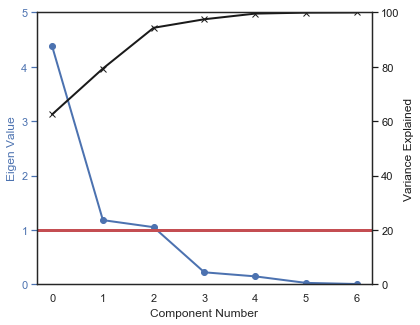

In [16]:
fig, ax1 = plt.subplots(figsize = (6, 5))
ax1.plot(pcamodel.explained_variance_, lw = 2, marker = 'o', color = 'b')
ax1.set_xlabel("Component Number")
ax1.set_ylabel("Eigen Value", color = 'b')
ax1.tick_params('y', colors = 'b')
ax1.axhline(y=1, color='r', lw =3)
ax1.set_ylim(0,5)

ax2 = ax1.twinx()
ax2.plot(np.cumsum(100*pcamodel.explained_variance_ratio_), lw = 2, marker = 'x', color = 'k')
ax2.set_ylabel("Variance Explained", color = 'k')
ax2.tick_params('y', colors = 'k')
ax2.set_ylim(0,100)

## PCA Biplot

Biplot is an interesting plot and contains lot of useful information.

It contains two plots:

* PCA scatter plot which shows first two component ( We already plotted this above)
* PCA loading plot which shows how strongly each characteristic influences a principal component.

### PCA Loading Plot

All vectors start at origin and their projected values on components explains how much weight they have on that component. Also, angles between individual vectors tells about correlation between them.

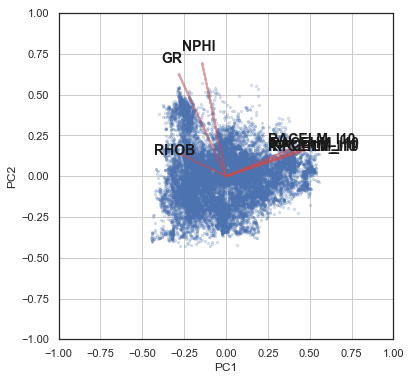

In [17]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5, alpha=0.2)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], lw = 2, color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], fontsize=14, fontweight = 'bold', color = 'k', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.grid()
    return True

plt.figure(figsize=(6,6))
myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(sdful.columns))
#myplot(pca[:,1:3],np.transpose(pcamodel.components_[1:3, :]),list(sdful.columns))
plt.show()

From all above analysis, it is clear that all resistivities are highly correlated and thus, redundant. Because we are later interested in using this dataset for facies mapping and supervised learning, we should keep the most representative resistivity to those. Keeping depth of investigation of RHOB, NPHI and GR, we should select the shallowest resistivity measurement with lowest noise and best range. In this case, it would be low frequency phase measurement or RPCELM_l10.

In [18]:
dful.columns

Index(['GR', 'RHOB', 'NPHI', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10',
       'RPCELM_l10'],
      dtype='object')

In [19]:
# Lets create a final dataset with dropped resistivities and also the standardized dataset.
fdful = dful.drop(['RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10'], 1)
fsdful = sdful.drop(['RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10'], 1)

# Data Reduction

Second motivation to do unsupervised learning in feature space is to reduce number of variables. This is especially in cases where we have many input measurements or features. Reduced variables are generally a linear combination. Again this is done to remove unwanted noise in the dataset to be used for subsequent dataset.

## Principal Component Analysis

Projected data on principle axis or eigenvectors is a linear combination of input measurements. Eigenvectors corresponding to eigenvalues below 1 are generally associated with high frequency noise in the dataset. In out case, from above analysis, we could observe that first 3 projections are significant and correspond to nearly 95% of the variance in our dataset. Let's plot those below.

In [20]:
# Now that we only have only 4 log measurements in the final dataset, 
# we would redo PCA to get only the first 2 principle components.

# This time we would also normalize the data
nfsdful = normalize(fsdful) 
# Convert to dataframe
nfsdful = pd.DataFrame(nfsdful, columns = fsdful.columns)

In [21]:
# Reduce the dimension to two principle components
pca = PCA(n_components=2)
rdful = pca.fit_transform(nfsdful)

In [22]:
# First create a new dataframe using the first 3 components of the PCA analysis we did above.
rdful = pd.DataFrame(rdful, columns = ["PC1", "PC2"])
rdful.head()

PC1       PC2
0  0.818718 -0.485069
1  0.817179 -0.512863
2  0.803581 -0.547163
3  0.770409 -0.588374
4  0.748792 -0.611054

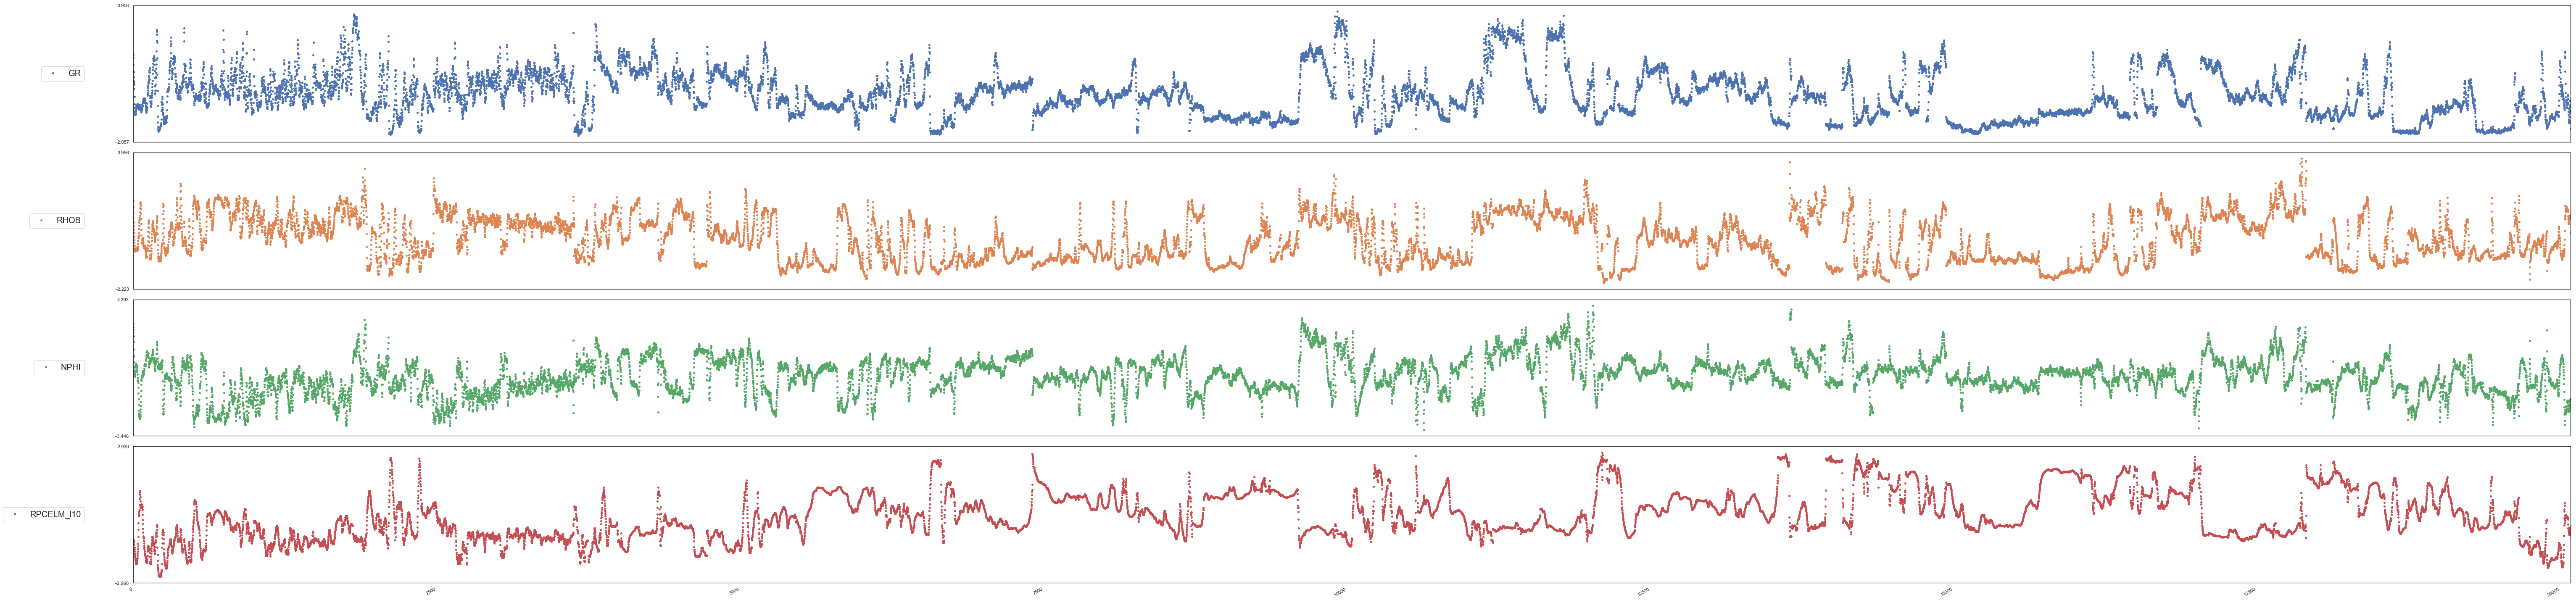

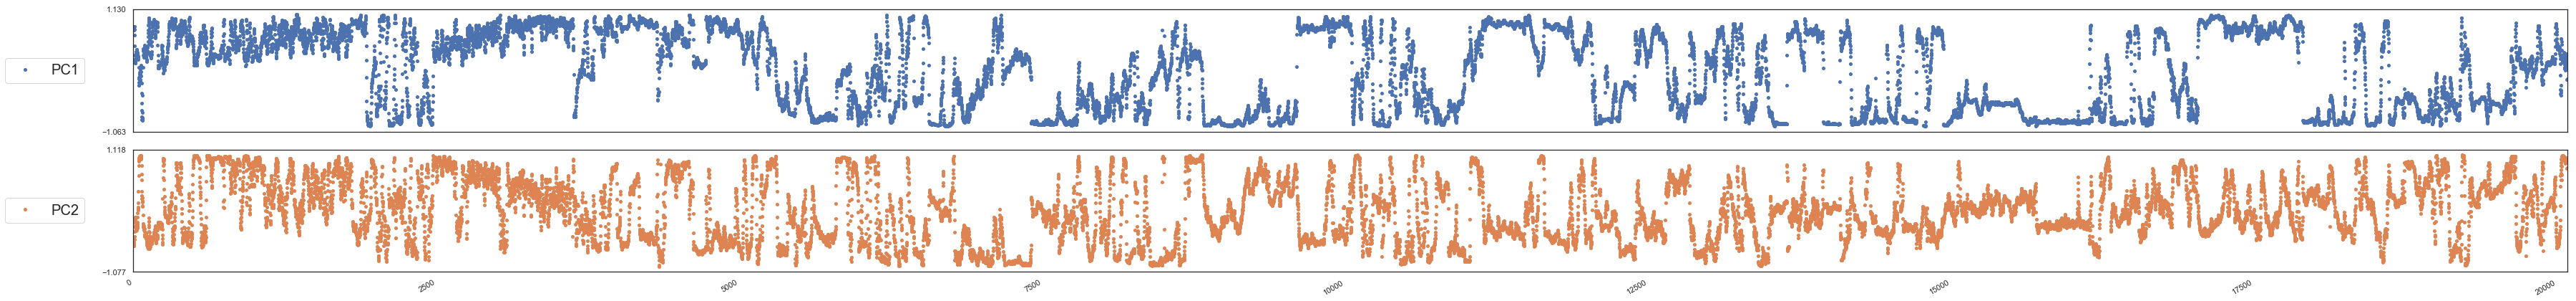

In [23]:
def logPlot(df, height=5, width = 50):
    axs = df.plot(subplots=True, lw =5, figsize = (width, height*df.shape[1]), linestyle='none', marker = 'o', markersize=4)
    for ax in axs:
        #ax.legend(loc = 'upper right', fontsize = 10)
        ax.legend(bbox_to_anchor = (-.02, 0.5), loc = 7, fontsize = 20, borderaxespad = 0.)
        #print ax.get_legend_handles_labels()[1]
        ymin, ymax = ax.get_ylim()
        ax.yaxis.set_ticks([ymin, ymax])
    plt.tight_layout()
    return axs

# Logplot the results from the new dataframe alongside the variables used to create those. 
logPlot(fsdful, 5, 85);
logPlot(rdful, 3);

# Unsupervised Learning - Sample Space

Unsupervised learning in sample or depth space generally refers to clustering. Clustering is a process whereby machine/algorithm tries to find similarity between unlabeled samples in a hyperdimensional space. 

We would use a number of methods available for clustering. See below for sklearn.cluster library. Read more at https://scikit-learn.org/stable/modules/clustering.html,

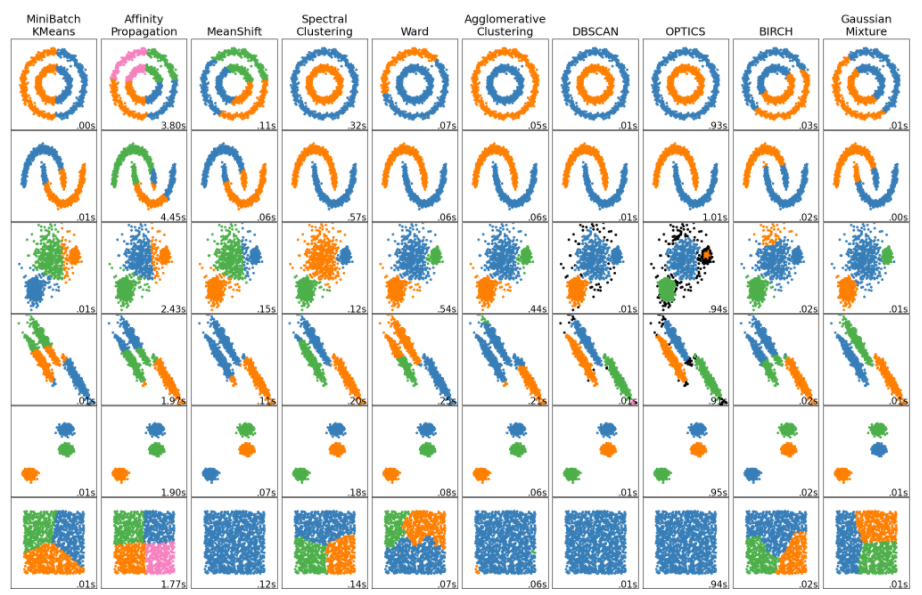


## KMeans

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

One main limitation of KMeans is the output clusters are spherical. Generally geoscientific data is not distributed spherically and thus, KMeans should be used with caution for facies or rock typing. 

In [24]:
# Import relevant libraries
from sklearn.cluster import KMeans
from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [25]:
def nOptimKMeans(df):
    score = []
    for k in range(1, 20):
        km = KMeans(init = 'k-means++', n_clusters=k, n_init=10)
        km.fit(df)
        score.append(km.inertia_)


    nPoints = len(score)
    #print(nPoints)
    allCoord = np.vstack((range(1, nPoints + 1), score)).T
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.tile(lineVecNorm, (nPoints, 1)), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine) + 1
    print("Optimum number of clusters - ", int(allCoord[idxOfBestPoint][0]))

    fig, ax = plt.subplots(figsize = (6, 6))
    ax.plot(range(1,20), score)
    ax.scatter(allCoord[idxOfBestPoint][0], allCoord[idxOfBestPoint][1], marker = 'o', s = 100, color = 'r')
    ax.set_xlim(1, 20)
    plt.xticks(np.arange(0, 20 , 1))
    ax.set_xlabel("Number of Clusters", fontsize = 12)
    ax.set_ylabel("Distortion", fontsize = 12)
    ax.grid(b=True)
    return int(allCoord[idxOfBestPoint][0])

def colorClusterPlot(df, xvar, yvar, labels):
    plt.figure(figsize=(6,6))
    plt.scatter(df[xvar], df[yvar], c = labels, cmap = 'gist_rainbow')
    plt.xlabel(xvar)
    plt.ylabel(yvar)
    plt.grid(True)
    return True

def colorClusterPlot2(ax, df, xvar, yvar, labels):
    ax.scatter(df[xvar], df[yvar], c = labels, cmap = 'gist_rainbow')
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    ax.grid(True)
    return True

## Using final standardized data

Lets try first KMeans with standardized data. 

Optimum number of clusters -  5


KMeans(n_clusters=5, n_init=50)

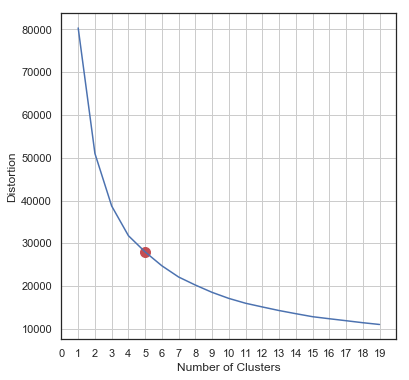

In [26]:
bestNClusters = nOptimKMeans(fsdful)
fskmeans = KMeans(init='k-means++', n_clusters = bestNClusters, n_init=50)
fskmeans.fit(fsdful)

True

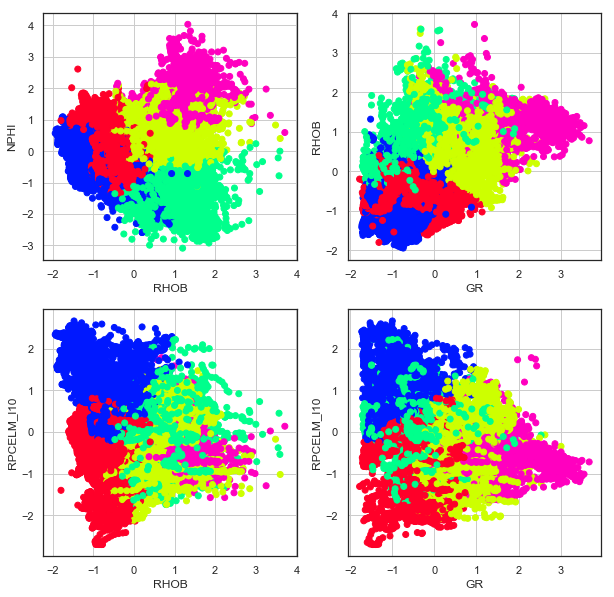

In [27]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
colorClusterPlot2(axs[0,0], fsdful, "RHOB", "NPHI", fskmeans.labels_)
colorClusterPlot2(axs[1,0], fsdful, "RHOB", "RPCELM_l10", fskmeans.labels_)
colorClusterPlot2(axs[0,1], fsdful, "GR", "RHOB", fskmeans.labels_)
colorClusterPlot2(axs[1,1], fsdful, "GR", "RPCELM_l10", fskmeans.labels_)

## Using final original data

Now with original data

Optimum number of clusters -  5


KMeans(n_clusters=5, n_init=50)

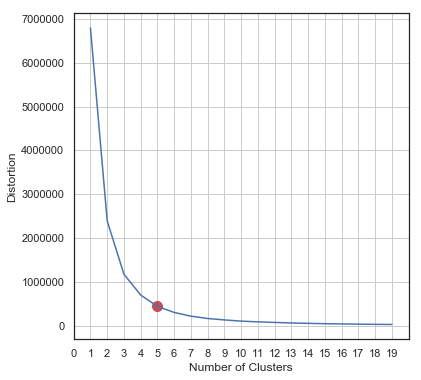

In [28]:
bestNClusters = nOptimKMeans(fdful)
fkmeans = KMeans(init='k-means++', n_clusters = bestNClusters, n_init=50)
fkmeans.fit(fdful)

True

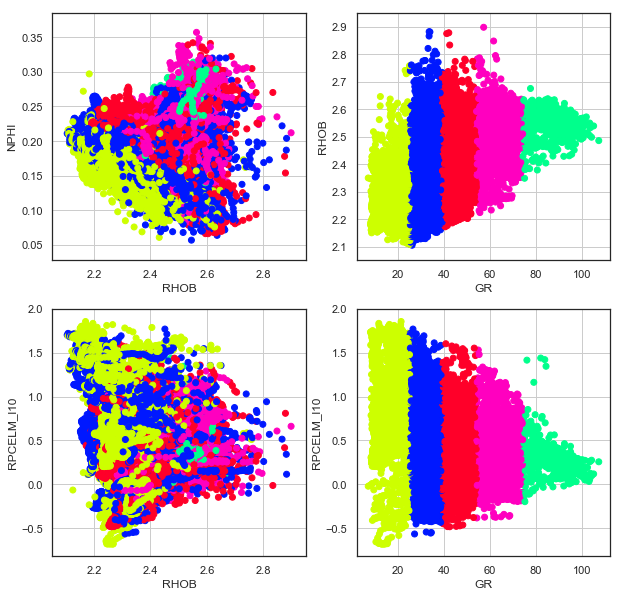

In [29]:
#colorClusterPlot(fdful, "RHOB", "NPHI", fkmeans.labels_)

fig, axs = plt.subplots(2,2, figsize=(10,10))
colorClusterPlot2(axs[0,0], fdful, "RHOB", "NPHI", fkmeans.labels_)
colorClusterPlot2(axs[1,0], fdful, "RHOB", "RPCELM_l10", fkmeans.labels_)
colorClusterPlot2(axs[0,1], fdful, "GR", "RHOB", fkmeans.labels_)
colorClusterPlot2(axs[1,1], fdful, "GR", "RPCELM_l10", fkmeans.labels_)

## Using reduced data

How about the reduced data?

Optimum number of clusters -  5


KMeans(n_clusters=5, n_init=50)

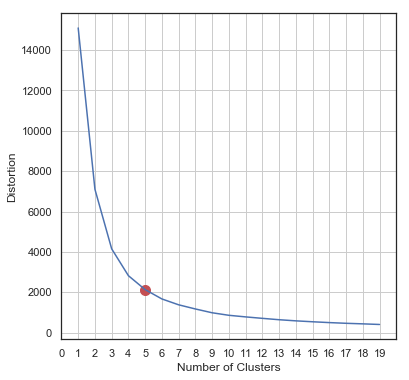

In [30]:
bestNClusters = nOptimKMeans(rdful)
rkmeans = KMeans(init='k-means++', n_clusters = bestNClusters, n_init=50)
rkmeans.fit(rdful)

True

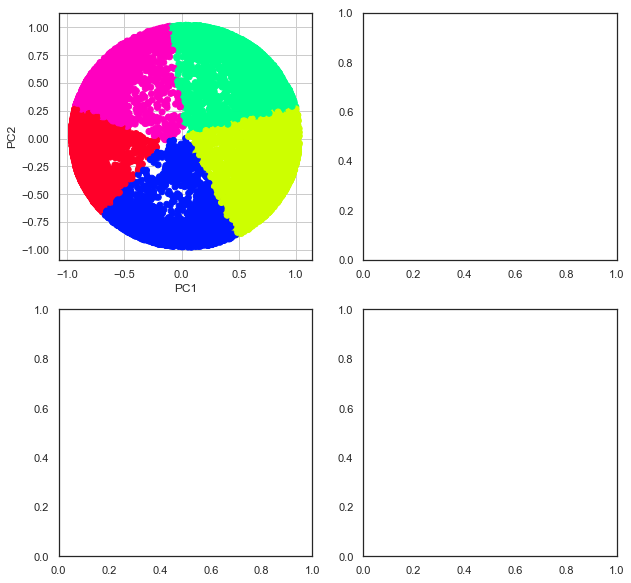

In [31]:
#colorClusterPlot(rdful, "PC1", "PC2", rkmeans.labels_)

fig, axs = plt.subplots(2,2, figsize=(10,10))
colorClusterPlot2(axs[0,0], rdful, "PC1", "PC2", rkmeans.labels_)
#colorClusterPlot2(axs[1,0], rdful, "PC1", "PC3", rkmeans.labels_)
#colorClusterPlot2(axs[0,1], rdful, "PC2", "PC3", rkmeans.labels_)
#colorClusterPlot2(axs[1,1], rdful, "GR", "RPCELM_l10", fkmeans.labels_)

True

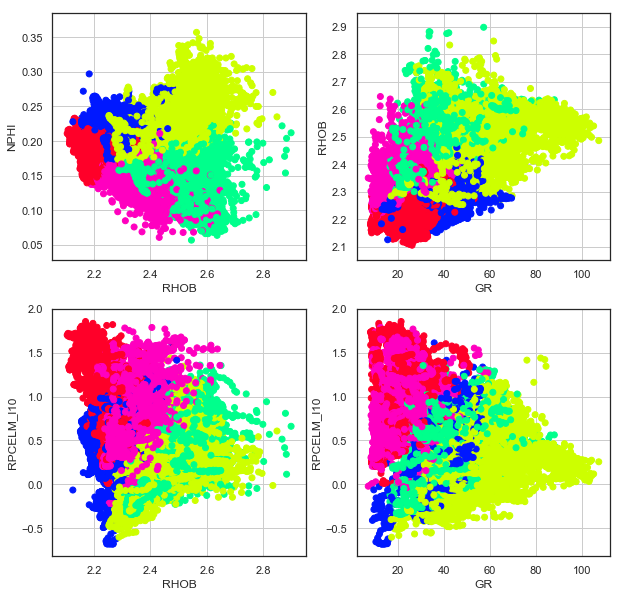

In [32]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
colorClusterPlot2(axs[0,0], fdful, "RHOB", "NPHI", rkmeans.labels_)
colorClusterPlot2(axs[1,0], fdful, "RHOB", "RPCELM_l10", rkmeans.labels_)
colorClusterPlot2(axs[0,1], fdful, "GR", "RHOB", rkmeans.labels_)
colorClusterPlot2(axs[1,1], fdful, "GR", "RPCELM_l10", rkmeans.labels_)

## GMM

While KMeans assume spherical clusters, GMM can use it as an initialization and then make those clusters gaussian. Much better!

In [33]:
from sklearn.mixture import GaussianMixture
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture

### Number of components(k) selection:

Silhouette score checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is. 

Since we already know that the fitting procedure is not deterministic, we run twenty fits for each number of clusters, then we consider the mean value and the standard deviation of the best five runs.

In [34]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [35]:
n_clusters=np.arange(2, 10)
sils=[]
sils_err=[]
iterations=10
for n in n_clusters:
    print(n)
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(rdful) 
        labels=gmm.predict(rdful)
        sil=metrics.silhouette_score(rdful, labels, metric='euclidean')
        #print("finished sil")
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

2
3
4
5
6
7
8
9


Text(0, 0.5, 'Score')

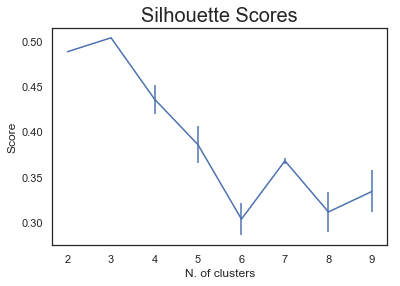

In [36]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

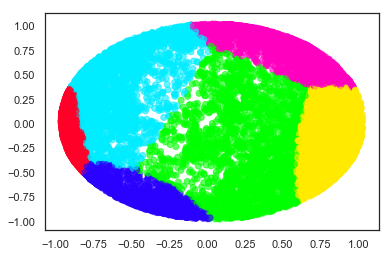

In [37]:
gmm = GaussianMixture(n_components = 6) 
gmm.fit(rdful)
gaussian_labels = gmm.fit_predict(rdful)
# Visualizing the clustering 
plt.scatter(rdful['PC1'], rdful['PC2'],  
           c = gaussian_labels, cmap ='gist_rainbow', alpha = 0.6) 
plt.show() 

True

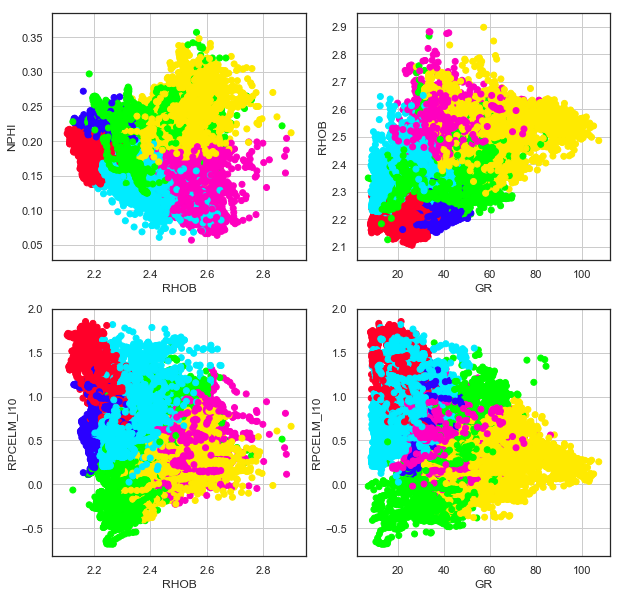

In [38]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
colorClusterPlot2(axs[0,0], fdful, "RHOB", "NPHI", gaussian_labels)
colorClusterPlot2(axs[1,0], fdful, "RHOB", "RPCELM_l10", gaussian_labels)
colorClusterPlot2(axs[0,1], fdful, "GR", "RHOB", gaussian_labels)
colorClusterPlot2(axs[1,1], fdful, "GR", "RPCELM_l10", gaussian_labels)

In [39]:
def create_plot_labels(dataframe, curves_to_plot, labels = {}, depth = [], log_curves=[]):
    """
    This create_plot function takes a number of arguments (inputs):
    wellname: the wellname as a string
    dataframe: the dataframe for the selected well
    curves_to_plot: a list of logging curves / dataframe columns we are wanting to plot
    depth_curve: the the depth curve we are wanting to plot against
    log_curves: a list of curves that need to be displayed on a logarithmic scale
    """
    # Count the number of tracks we need
    num_tracks = len(curves_to_plot) + len(labels)
    
    # Setup the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, sharey=True, figsize=(num_tracks*2, 10))
    
    # Create a super title for the entire plot
    #fig.suptitle(wellname, fontsize=20, y=1.05)
    
    # Loop through each curve in curves_to_plot and create a track with that data
    
    if len(depth) == 0:
        depth = dataframe.index.values
    
    for i, curve in enumerate(curves_to_plot):
        
        ax[i].plot(dataframe[curve], depth, linestyle='none', marker='o', markersize=2)
        
        # Setup a few plot cosmetics
        ax[i].set_title(curve, fontsize=14, fontweight='bold')
        ax[i].grid(which='major', color='lightgrey', linestyle='-')
        
        # We want to pass in the deepest depth first, so we are displaying the data 
        # from shallow to deep
        ax[i].set_ylim(depth.max(), depth.min())

        # Only set the y-label for the first track. Hide it for the rest
        if i == 0:
            ax[i].set_ylabel('Sample Number', fontsize=18, fontweight='bold')
        else:
            plt.setp(ax[i].get_yticklabels(), visible = False)
        
        # Check to see if we have any logarithmic scaled curves
        if curve in log_curves:
            ax[i].set_xscale('log')
            ax[i].grid(which='minor', color='lightgrey', linestyle='-')
    
    n_curve_tracks = len(curves_to_plot)
    
    color = plt.cm.tab10
    
    for i, label in enumerate(labels.items()):
        j = n_curve_tracks + i
        label_name, label_values = label
        #ax[j].plot(label_values, depth)
        ax[j].set_ylim(depth.max(), depth.min())
        ax[j].set_title(label_name, fontsize=14, fontweight='bold')
        for k in np.unique(label_values):
            ax[j].fill_betweenx(depth, label_values.min(), label_values.max(), where=label_values== k, color=color(k), alpha=0.5)
    
    plt.tight_layout()
    plt.show()

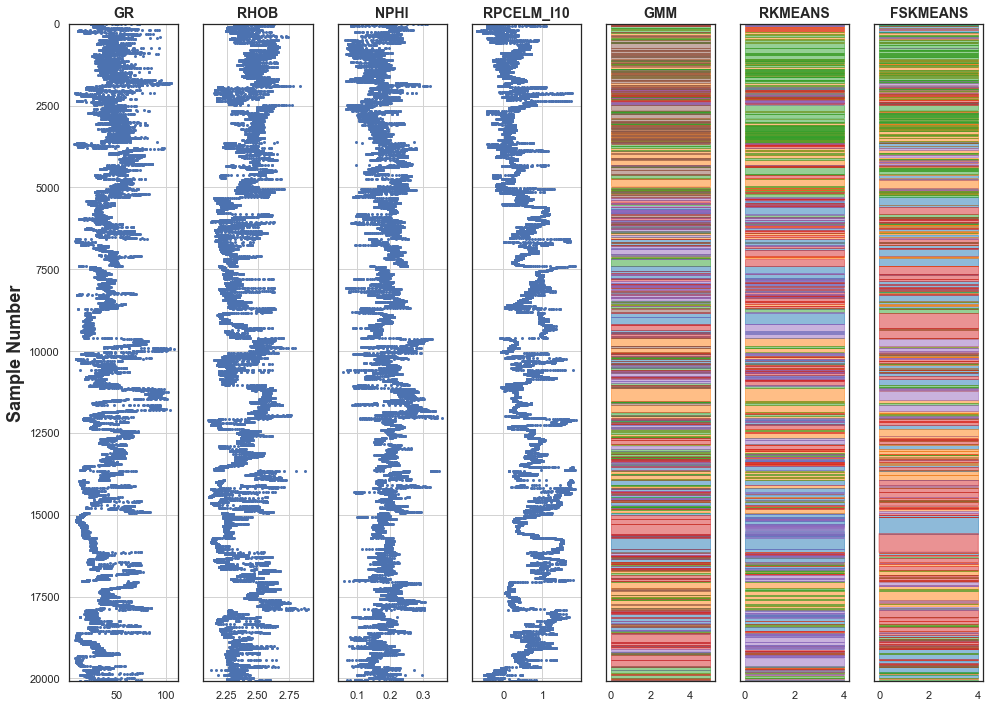

In [40]:
labels_dict = {"GMM":gaussian_labels, "RKMEANS":rkmeans.labels_, "FSKMEANS":fskmeans.labels_} #, "FKMEANS":fkmeans.labels_}

create_plot_labels(fdful, fdful.columns, labels_dict)

In [41]:
ldf = df.assign(GMM = gaussian_labels, RKMEANS=rkmeans.labels_, FSKMEANS = fskmeans.labels_)

3224.9
4744.0


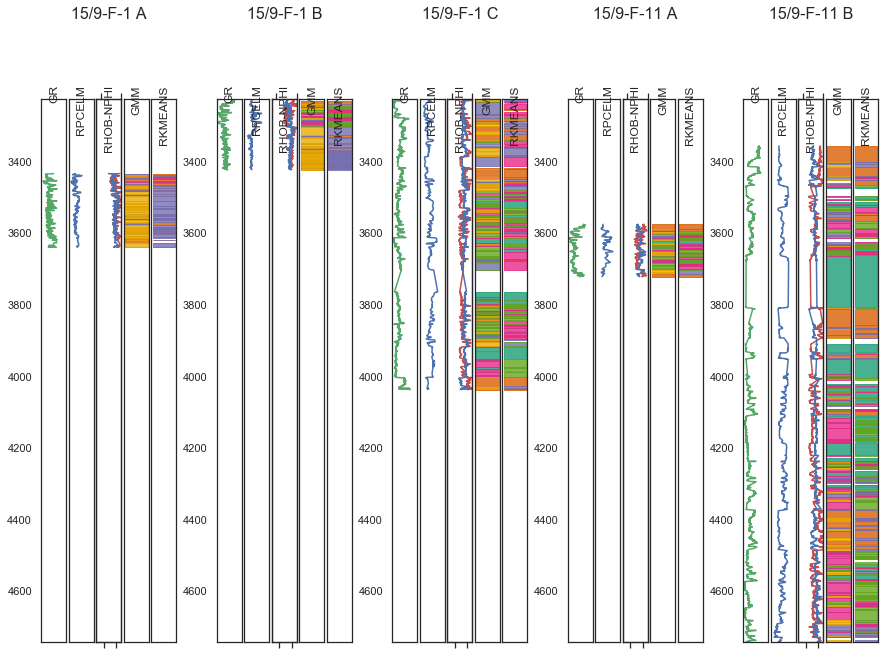

In [43]:
nplots = len(wellnames)

mindepth = ldf['MD'].min()
print(mindepth)
maxdepth = ldf['MD'].max()
print(maxdepth)

lcolor = plt.cm.Dark2

fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(1, nplots, wspace=0.3)

for i in range(nplots):
    tdf = ldf[ldf['wellName'] == wellnames[i]]
    label_values = tdf['GMM']
    inner = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=outer[i], wspace = 0.1)

    
    axo = plt.Subplot(fig, outer[i])
    axo.set_title(wellnames[i], pad=80.0, fontsize = 16)
    axo.axis('off')
    fig.add_subplot(axo)
    
    ax1 = plt.Subplot(fig, inner[0])
    ax1.set_title("GR", rotation=90)
    ax1.plot(tdf['GR'], tdf['MD'], color = 'g')
    ax1.set_ylim(maxdepth, mindepth)
    ax1.set_xlim(0, 150)
    ax1.set_xticklabels(ax1.get_xticks(), rotation = 90, visible = False)
    fig.add_subplot(ax1)
    
    ax2 = plt.Subplot(fig, inner[2])
    ax2.set_title("RHOB-NPHI", rotation=90)
    ax2.plot(tdf['RHOB'], tdf['MD'], color='r')
    ax2.set_xlim(1.7, 2.7)
    ax2.set_xticklabels(ax2.get_xticks(), rotation = 90, visible = False)
    ax2.set_ylim(maxdepth, mindepth)
    fig.add_subplot(ax2, sharey=ax1)
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    ax22 = ax2.twiny()
    ax22.plot(tdf['NPHI'], tdf['MD'], color = 'b')
    ax22.set_xlim(0.6,0)
    ax22.set_xticklabels(ax22.get_xticks(), rotation = 90, visible = False)
    
    ax3 = plt.Subplot(fig, inner[1])
    ax3.set_title("RPCELM", rotation=90)
    ax3.plot(tdf['RPCELM_l10'], tdf['MD'])
    ax3.set_xlim(-1, 3)
    ax3.set_xticklabels(ax3.get_xticks(), rotation = 90, visible = False)
    ax3.set_ylim(maxdepth, mindepth)
    fig.add_subplot(ax3, sharey=ax1)
    plt.setp(ax3.get_yticklabels(), visible=False)
    
    ax4 = plt.Subplot(fig, inner[3])
    ax4.set_title("GMM", rotation=90)
    for k in np.unique(label_values):
            ax4.fill_betweenx(tdf['MD'], tdf['GMM'].min(), tdf['GMM'].max(), where=tdf['GMM']== k, color=lcolor(k), alpha=0.8)
    ax4.set_ylim(maxdepth, mindepth)
    ax4.set_xticklabels(ax4.get_xticks(), rotation = 90, visible = False)
    fig.add_subplot(ax4, sharey=ax1)
    plt.setp(ax4.get_yticklabels(), visible=False)
    
    ax5 = plt.Subplot(fig, inner[4])
    ax5.set_title("RKMEANS", rotation=90)
    for k in np.unique(label_values):
            ax5.fill_betweenx(tdf['MD'], tdf['RKMEANS'].min(), tdf['RKMEANS'].max(), where=tdf['RKMEANS']== k, color=lcolor(k), alpha=0.8)
    ax5.set_ylim(maxdepth, mindepth)
    ax5.set_xticklabels(ax5.get_xticks(), rotation = 90, visible = False)
    fig.add_subplot(ax5, sharey=ax1)
    plt.setp(ax5.get_yticklabels(), visible=False)


## Other Methods

These are some of the methods available in sklearn.cluster library. Give it a try and see how they do? Also read about these at https://scikit-learn.org/stable/modules/clustering.html. Remember we are working with nornmalized data. 

In [44]:
def plot_clusters(df, xvar, yvar, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(df)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.figure(figsize=(6,6))
    plt.scatter(df[xvar], df[yvar], c=colors) #, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return labels

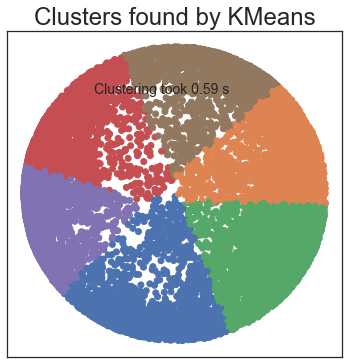

In [45]:
kmeans_labels = plot_clusters(rdful, "PC1", "PC2", cluster.KMeans, (),  {'n_clusters':6})

c:\users\banamz\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass bandwidth=0.175 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


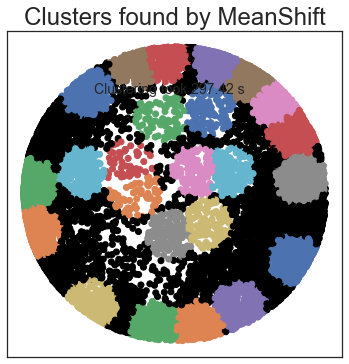

In [46]:
MS_labels = plot_clusters(rdful, "PC1", "PC2", cluster.MeanShift, (0.175,), {'cluster_all':False})

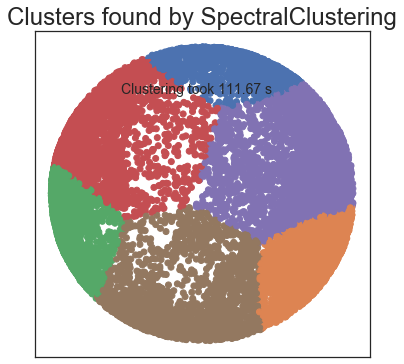

In [47]:
SC_labels = plot_clusters(rdful, "PC1", "PC2", cluster.SpectralClustering, (), {'n_clusters':6})

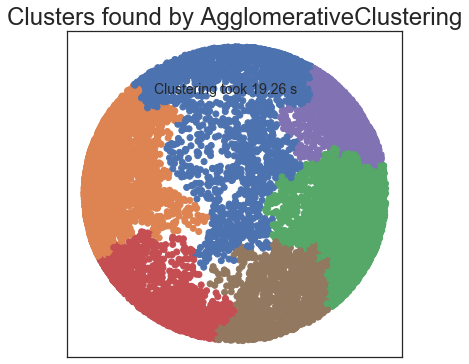

In [48]:
AC_labels = plot_clusters(rdful, "PC1", "PC2", cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

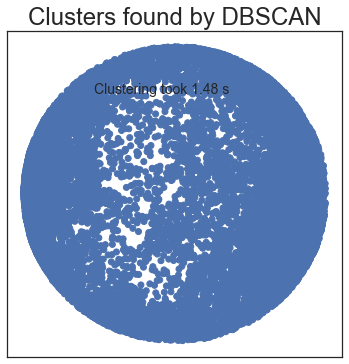

In [49]:
DB_labels = plot_clusters(rdful, "PC1", "PC2", cluster.DBSCAN, (), {'eps':0.3})

Lets plot the labels on concatendate data

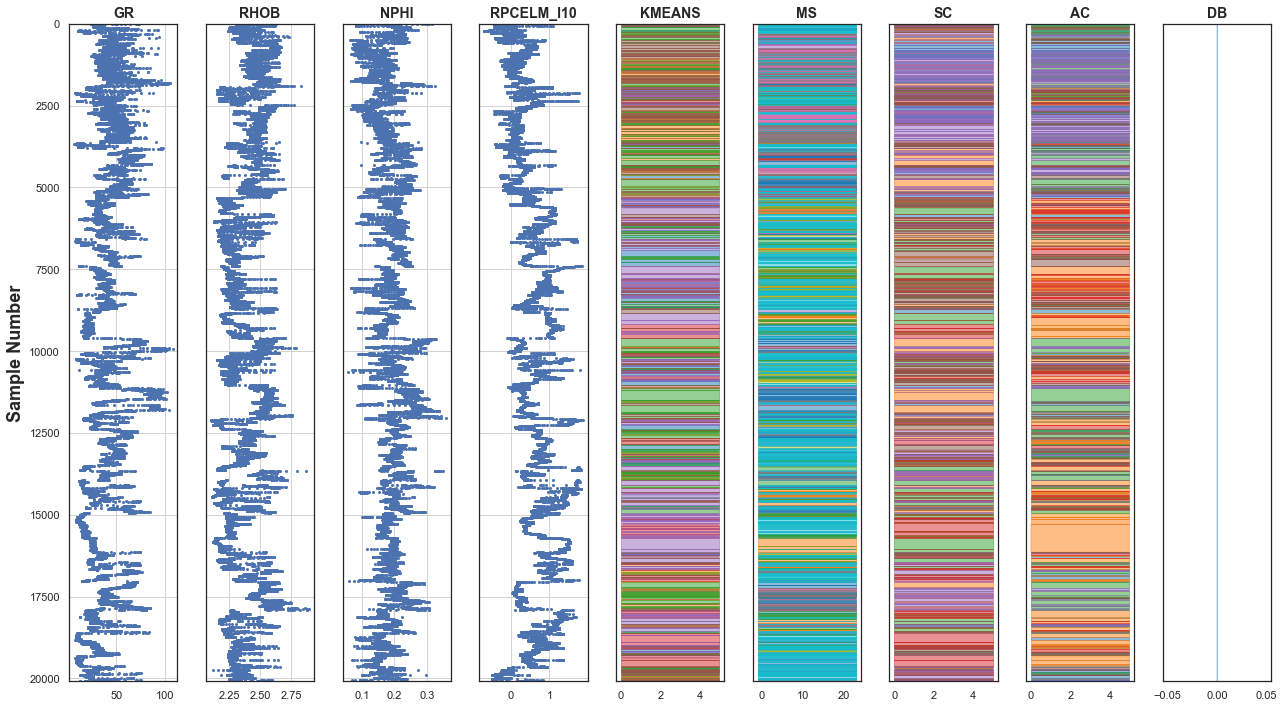

In [50]:
labels_dict = {"KMEANS":kmeans_labels, "MS":MS_labels, "SC":SC_labels, "AC": AC_labels, "DB":DB_labels} #, "FKMEANS":fkmeans.labels_}

create_plot_labels(fdful, fdful.columns, labels_dict)